# Polar codes BER/FER simulation

This notebook shows how to build a polar encoder and decoder. 

## Objectives

At the end of this notebook, you should be able to :
* Use the `frozenbits_generator` tool of `py_aff3ct` to generate and load a frozen bits vector
* Build and bind a polar encoder
* Build and bind a polar decoder (SC, SCL, CA-SCL, ...)

## Import librairies

In order to use polar codes, one needs to use the following tools : `frozenbits_generator` and `noise`.
The frozen bits generator supports several methods for the generation of frozen bits. 

In [2]:
import sys
sys.path.insert(0, '../../build/lib')
import numpy as np
import time
import math
import matplotlib.pyplot as plt

import py_aff3ct
import py_aff3ct.tools.frozenbits_generator as tool_fb
import py_aff3ct.tools.noise as tool_noise

## Generate and load the frozen bits

* Here we use a Gaussian Approximation to generate the frozen bits of the polar code. Other generators are available. 
* We also use the `noise` tool to set the noise level for which the frozen bits should be generated.
* In this simulation, we use a different set of frozen bits for each simulated SNR.

In [ ]:
K = 512
N = 1024
bps = 4      # Bits per Symbols   
Ns  = N//bps # Packet size in symbols

ebn0_min = 6.0
ebn0_max = 12.0
ebn0_step = 0.25

ebn0 = np.arange(ebn0_min,ebn0_max,ebn0_step)
esn0 = ebn0 + 10 * math.log10(K/N)
sigma_vals = 1/(math.sqrt(2) * 10 ** (esn0 / 20))

# create a frozen bit generator
fbgen = tool_fb.Frozenbits_generator_GA_Arikan(K, N)
# create a noise tool
noise = tool_noise.Sigma(sigma_vals[0])
# set the noise for which the frozen bits should be generated
fbgen.set_noise(noise)
# generate and store the forzen bits
frozen_bits = fbgen.generate()

## Build the modules

The polar encoder and decoder both need the code dimension `K`, the code length `N` and the `frozen_bits`.

In [ ]:
src  = py_aff3ct.module.source.Source_random           (K      )             # Build source
enc  = py_aff3ct.module.encoder.Encoder_polar_sys      (K,N,frozen_bits)     # Build the encoder
cstl = py_aff3ct.tools.constellation.Constellation_QAM (bps    )             # Setup constellation tool
mdm  = py_aff3ct.module.modem.Modem_generic            (N, cstl)             # Build the modem
chn  = py_aff3ct.module.channel.Channel_AWGN_LLR       (2*Ns   )             # Build the channel (Ns complex symbols = 2Ns real dims)
dec  = py_aff3ct.module.decoder.Decoder_polar_SC_fast_sys(K,N,frozen_bits)   # Build the decoder
mnt  = py_aff3ct.module.monitor.Monitor_BFER_AR        (K,100  )             # Build the monitor (counting errors)

enc["encode       ::U_K "] = src["generate   ::U_K "   ]
mdm["modulate     ::X_N1"] = enc["encode     ::X_N "   ]
chn["add_noise    ::X_N "] = mdm["modulate   ::X_N2"   ]
mdm["demodulate   ::Y_N1"] = chn["add_noise  ::Y_N "   ]
dec["decode_siho  ::Y_N "] = mdm["demodulate ::Y_N2"   ]
mnt["check_errors ::U   "] = src["generate   ::U_K "   ]
mnt["check_errors ::V   "] = dec["decode_siho::V_K "   ]

sigma = np.ndarray(shape = (1,1),  dtype = np.float32)
chn[ 'add_noise::CP'] = sigma
mdm['demodulate::CP'] = sigma

fer = np.zeros(len(ebn0))
ber = np.zeros(len(ebn0))

## Simulation loop

As mentioned before, in this simulation, we use a different set of frozen bits for each simulated SNR.

 Eb/NO (dB) | Frame number |    BER   |    FER   |  Tpt (Mbps)
------------|--------------|----------|----------|------------
       6.00 |          100 | 2.63e-01 | 1.00e+00 |       1.02
       6.25 |          100 | 2.56e-01 | 1.00e+00 |       1.04
       6.50 |          100 | 2.48e-01 | 1.00e+00 |       1.06
       6.75 |          100 | 2.47e-01 | 1.00e+00 |       1.07
       7.00 |          100 | 2.41e-01 | 1.00e+00 |       1.07
       7.25 |          100 | 2.36e-01 | 1.00e+00 |       1.07
       7.50 |          100 | 2.34e-01 | 1.00e+00 |       1.05
       7.75 |          100 | 2.29e-01 | 1.00e+00 |       1.07
       8.00 |          100 | 2.26e-01 | 1.00e+00 |       1.08
       8.25 |          100 | 2.22e-01 | 1.00e+00 |       1.07
       8.50 |          100 | 2.15e-01 | 1.00e+00 |       1.09
       8.75 |          100 | 2.04e-01 | 1.00e+00 |       1.06
       9.00 |          100 | 1.95e-01 | 1.00e+00 |       1.10
       9.25 |          100 | 1.98e-01 | 1.00e+00 |       1.10
      

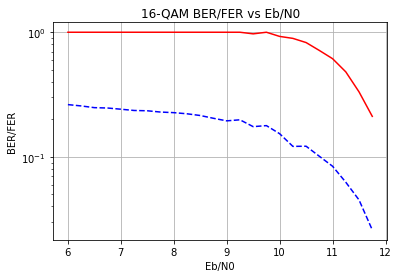

In [3]:



print(" Eb/NO (dB) | Frame number |    BER   |    FER   |  Tpt (Mbps)")
print("------------|--------------|----------|----------|------------")
for i in range(len(sigma_vals)):
	mnt.reset()
	sigma[:] = sigma_vals[i]
	# set the new noise value
	noise = py_aff3ct.tools.noise.Sigma(sigma_vals[i])	
	fbgen.set_noise(noise)
	# generate the new set of frozen bits
	frozen_bits = fbgen.generate()
	# update the frozen bits values for both encoder and decoder
	enc.set_frozen_bits(frozen_bits)
	dec.set_frozen_bits(frozen_bits)

	t = time.time()
	while not mnt.is_done():
		src['generate'    ].exec()
		enc['encode'      ].exec()
		mdm['modulate'    ].exec()
		chn['add_noise'   ].exec()
		mdm['demodulate'  ].exec()
		dec['decode_siho' ].exec()
		mnt['check_errors'].exec()
	elapsed = time.time() - t
	total_fra = mnt.get_n_analyzed_fra()

	ber[i] = mnt.get_ber()
	fer[i] = mnt.get_fer()

	tpt = total_fra * K * 1e-6/elapsed
	print("%11.2f | %12d | %7.2e | %7.2e | %10.2f"%(ebn0[i], total_fra, ber[i], fer[i], tpt))
    

fig = plt.figure()
plt.title("16-QAM BER/FER vs Eb/N0")
plt.xlabel("Eb/N0")
plt.ylabel("BER/FER")
plt.grid()
plt.semilogy(ebn0, fer, 'r-', ebn0, ber, 'b--')
plt.show()

